In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg


In [13]:
data = pd.read_csv('extended_stoma_dataset.csv')

In [14]:
data.head()

,Unnamed: 0,dates,id,not_registered,num_caries,num_filling_caries,num_filling_no_caries,num_healthy,num_removed_caused_by_caries,num_removed_other_reasons,...,sealed fissure,uncut tooth,age,nationality,date_of_birth,place_of_birth,previous_place_of_living,bite_type,fluorosis,sum_hygiene_index
0,0,2011-2012,1302.xlsx,4,3,0,0,21,0,0,...,0,0,18.0,русский,11.04.01,Мурманск,Мурманск,ортогнатический,0,2.0
1,1,2012-2013,1302.xlsx,4,3,0,0,21,0,0,...,0,0,18.0,русский,11.04.01,Мурманск,Мурманск,ортогнатический,0,2.0
2,2,2013-2014,1302.xlsx,0,4,0,1,23,0,0,...,0,0,18.0,русский,11.04.01,Мурманск,Мурманск,ортогнатический,0,2.0
3,3,2014-2015,1302.xlsx,0,4,0,3,21,0,0,...,0,0,18.0,русский,11.04.01,Мурманск,Мурманск,ортогнатический,0,2.0
4,4,2015-2016,1302.xlsx,0,2,1,4,22,0,0,...,0,0,18.0,русский,11.04.01,Мурманск,Мурманск,ортогнатический,0,2.0


In [15]:
data['end_year'] = data.dates.apply(lambda a: int(a.split('-')[1]))
data['birth_year'] = data['date_of_birth'].apply(lambda a: int('20'+a.split('.')[-1] ))
data['right_age'] = data[['end_year', 'birth_year']].apply(lambda a: a[0]-a[1], axis=1)
data['kpu'] = data[['num_caries', 'num_filling_caries',
                    'num_filling_no_caries', 
                    'num_removed_caused_by_caries', 'num_removed_other_reasons']].sum(axis=1)
train = data.drop(data[data['dates'] == '2017-2018'].index, axis=0) 
test = data[data['dates'] == '2017-2018']


3214.xlsx


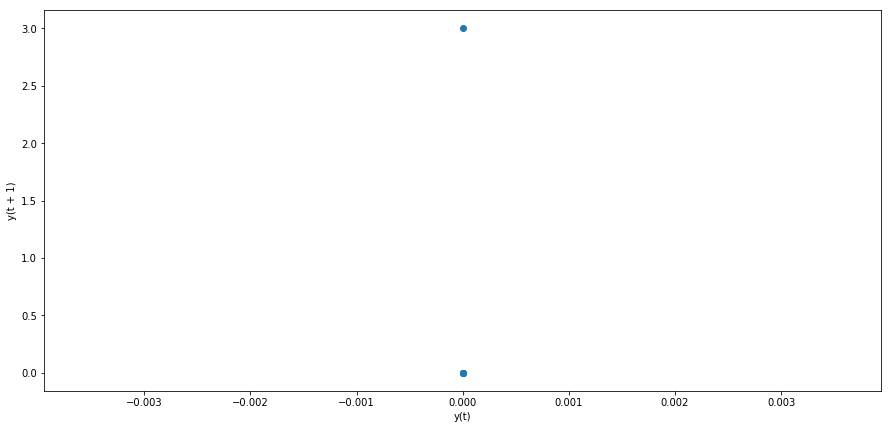

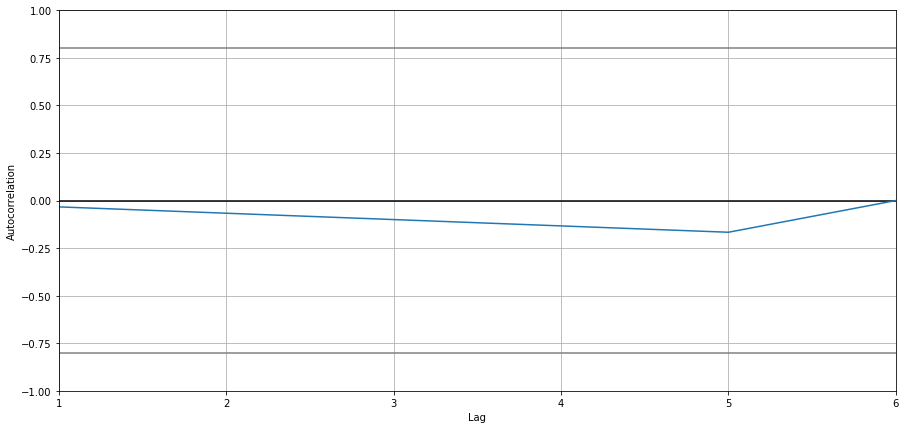

1114.xlsx


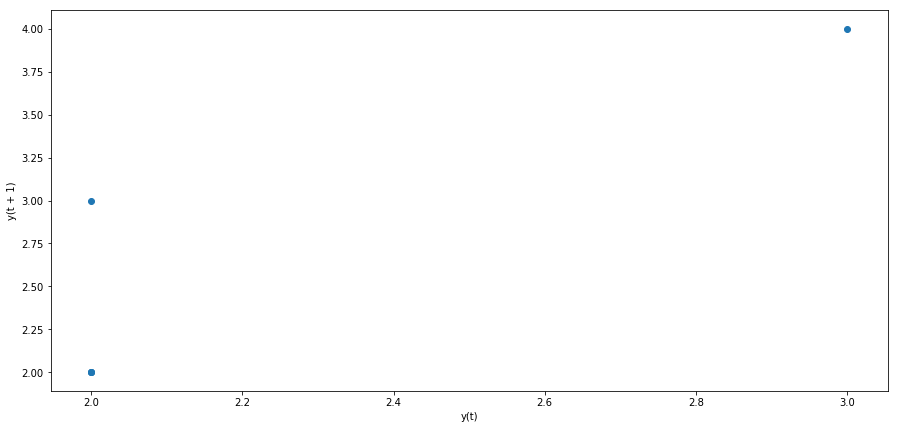

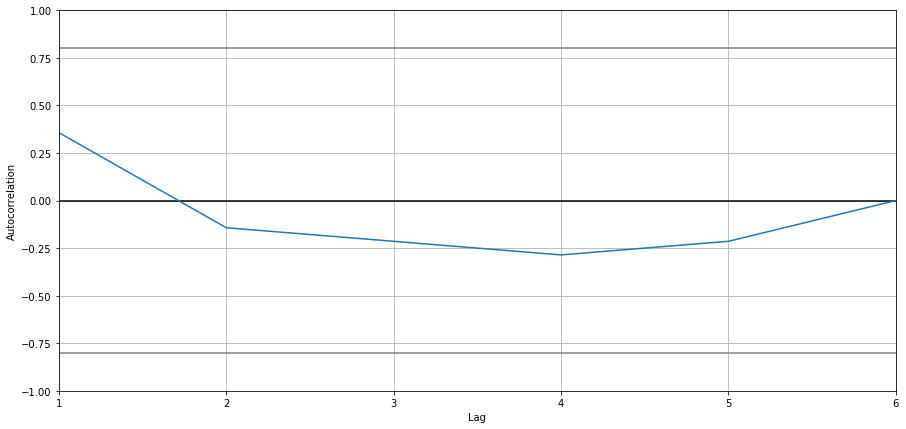

3314.xlsx


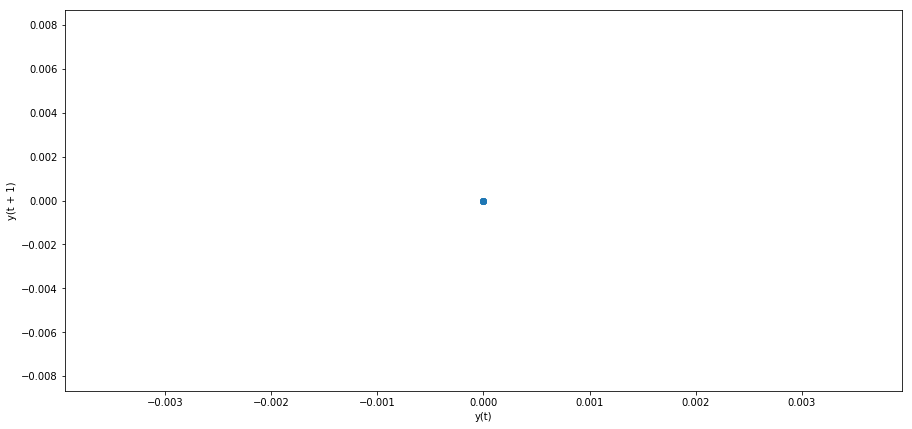

/Applications/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/misc.py:414: RuntimeWarning: invalid value encountered in double_scalars
  return ((data[: n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0


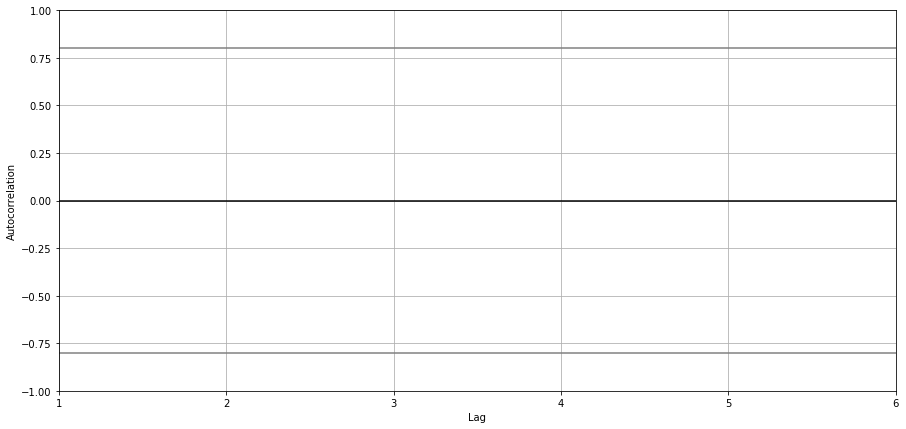

3416.xlsx


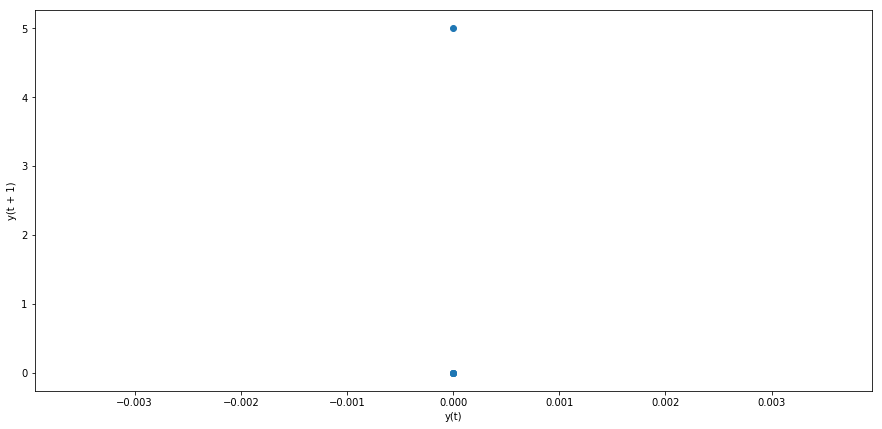

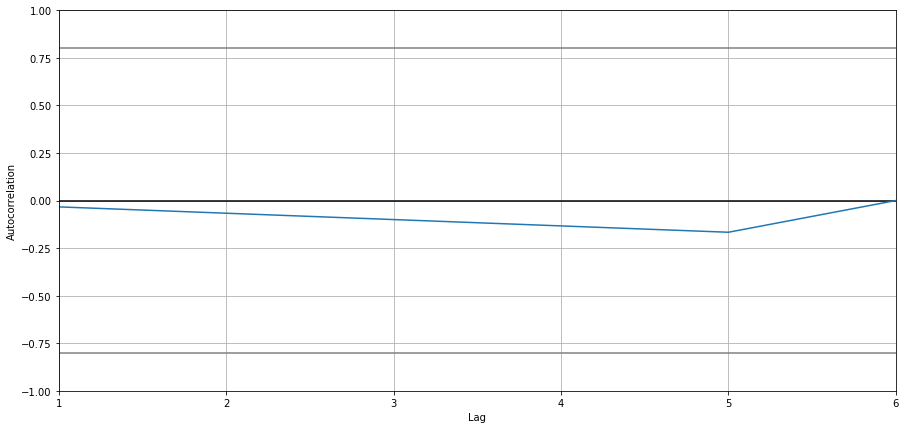

7318.xlsx


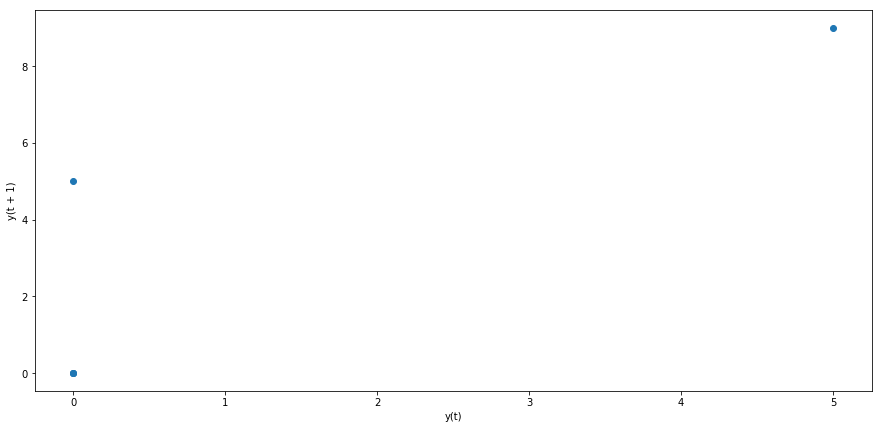

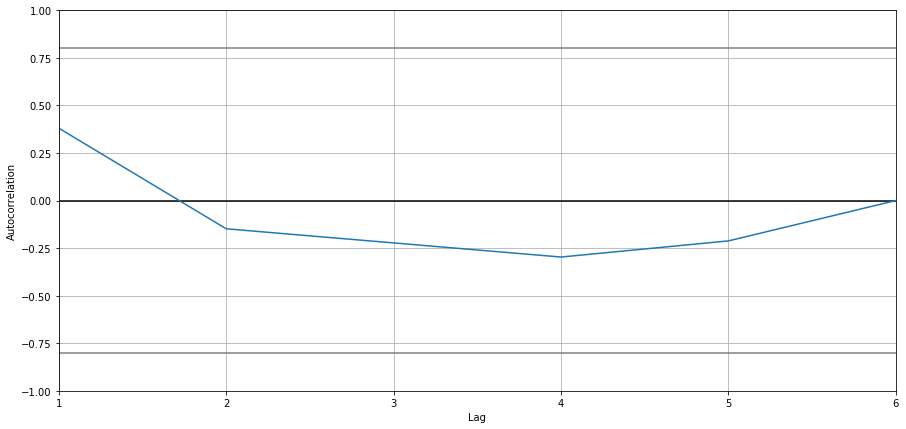

7215.xlsx


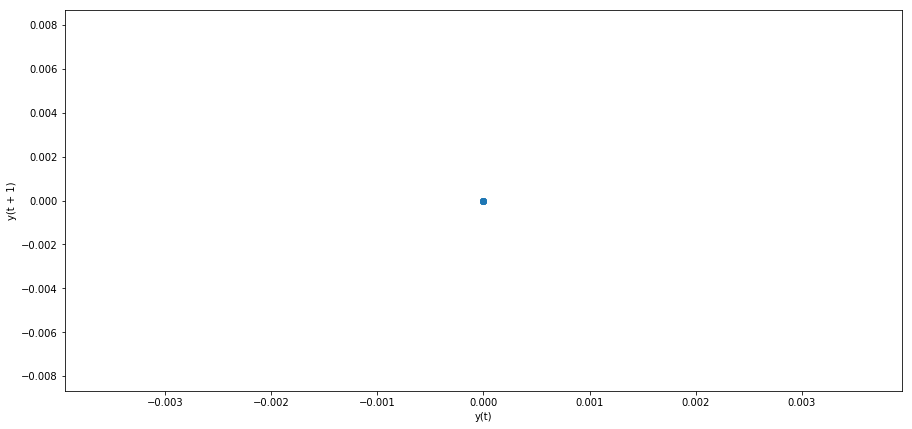

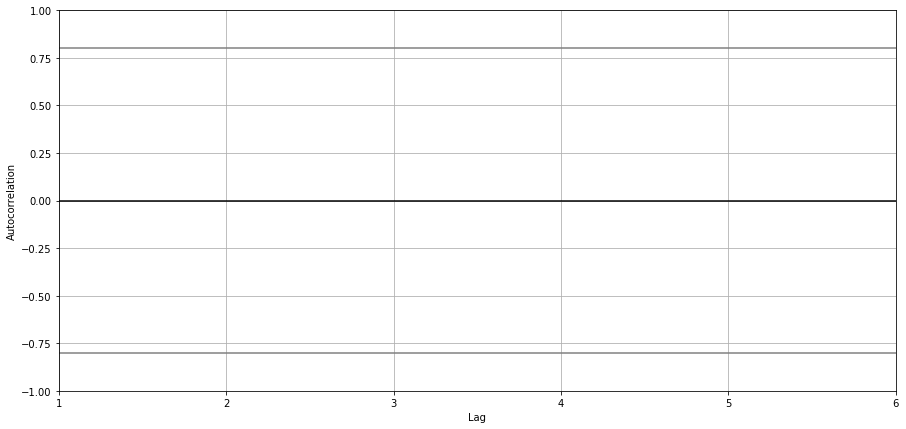

1216.xlsx


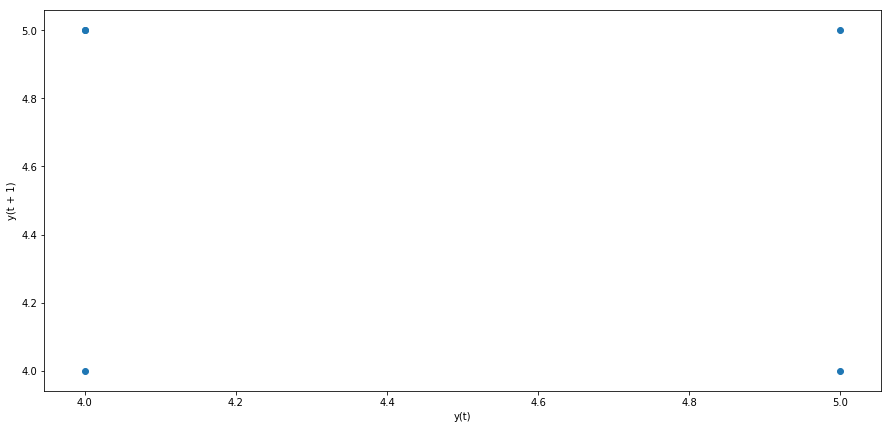

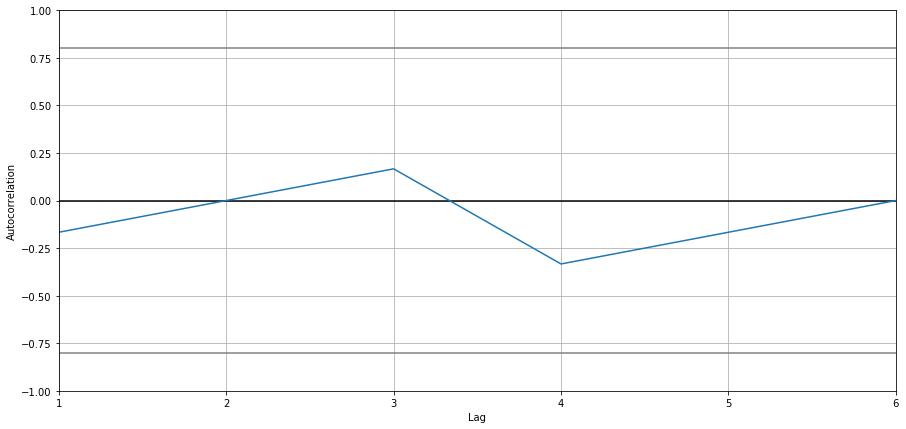

7405.xlsx


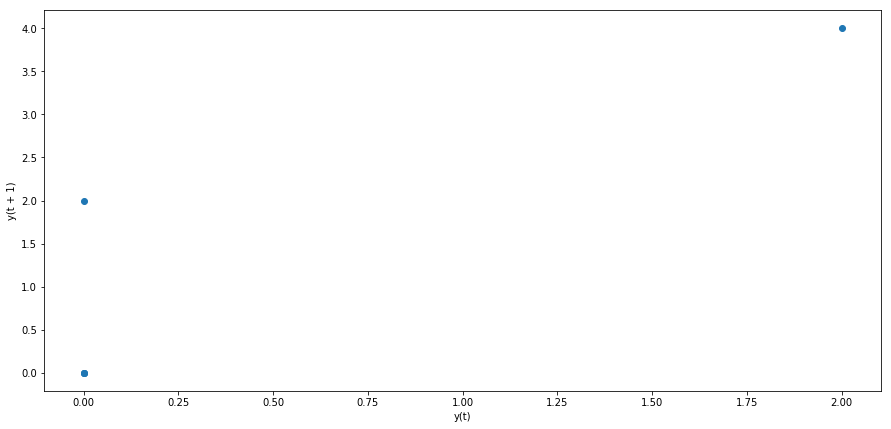

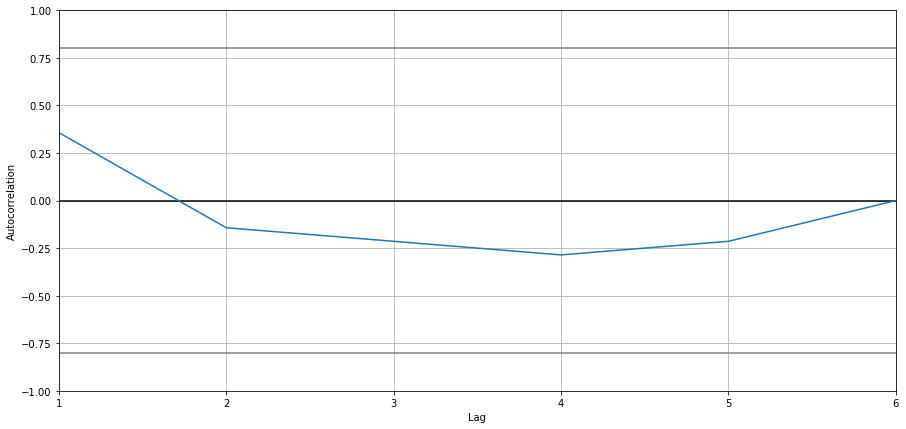

1114.xlsx


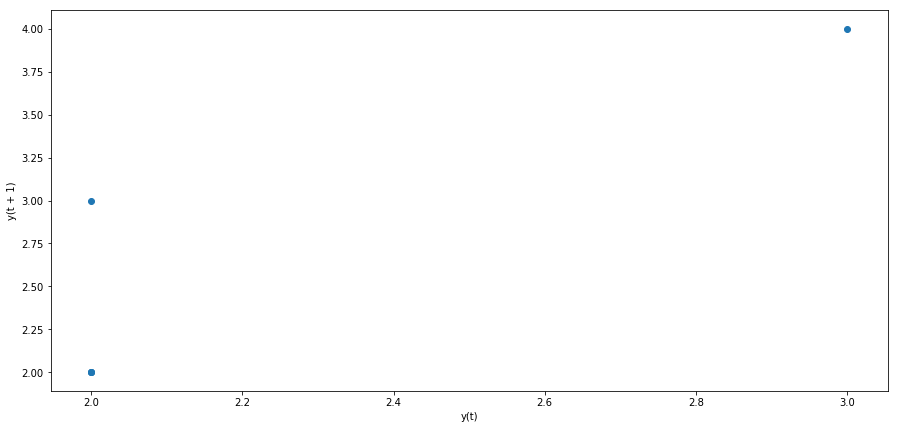

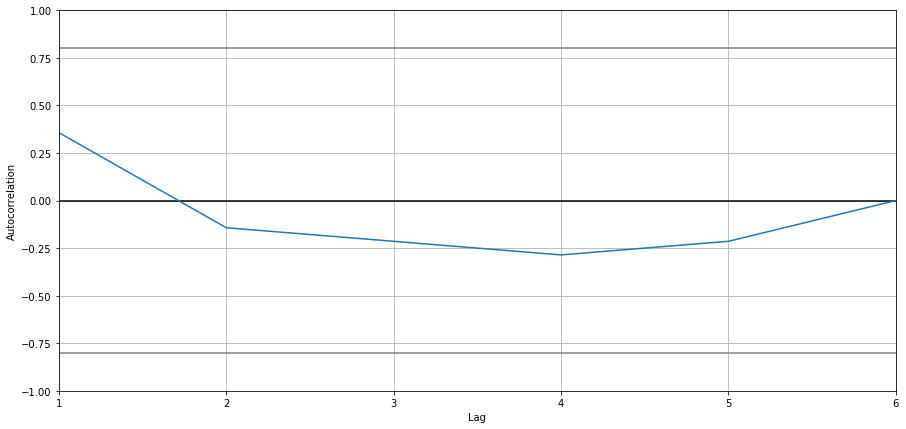

3106.xlsx


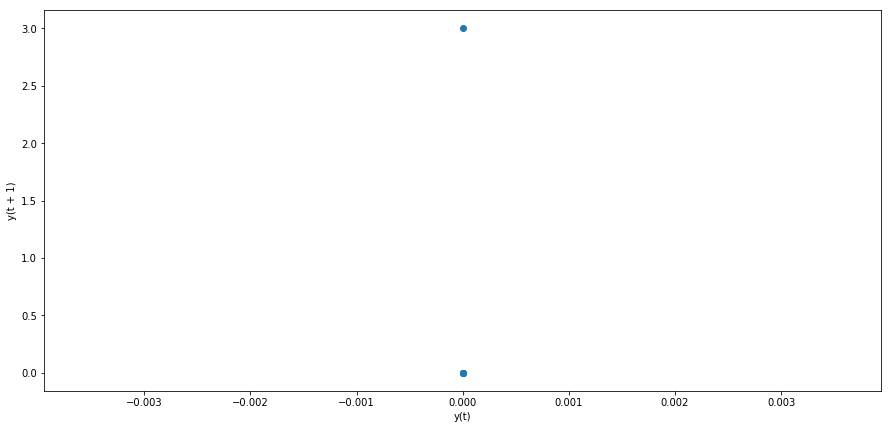

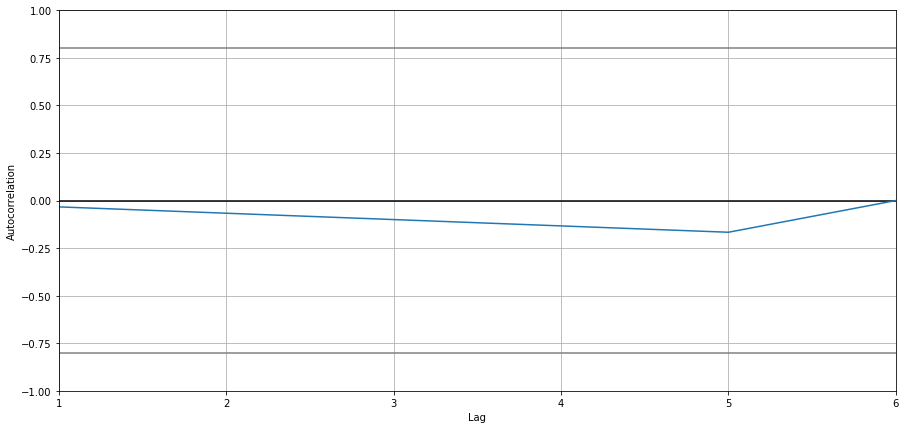

In [16]:
random_patient_sample = np.random.choice(data['id'], 10) 
for idx in random_patient_sample:
    print(idx)
    series = train[train['id'] == idx]['kpu']

    plt.figure(figsize=(15, 7))
    lag_plot(series)
    plt.show()

    plt.figure(figsize=(15, 7))
    autocorrelation_plot(series)
    plt.show()

# Baseline
Prediction of future KPU with KPU of the previous year

In [17]:
y_pred = train[['id', 'kpu']].groupby('id').last()
y_true = test[['id', 'kpu']].groupby('id').last()
score = np.sqrt( mean_squared_error(y_true, y_pred ))
score

1.334205648332327

In [18]:
#comparing with a standard deviation of a target variable
data[['id', 'kpu']].groupby('id').std().mean()

kpu    1.920244
dtype: float64

# Training AutoRegression per each cadet using only KPU as feature

In [24]:
x_train = train[['id', 'kpu']]

In [25]:
x_train.id.nunique()


191

# Can not be used for too short time series

In [38]:
scores = []

for idx in x_train.id.unique():
    train_series = x_train['kpu'][x_train['id'] == idx].values
#     print(train_series)
    y_true_series = y_true.loc[idx] 
    model = AutoReg(train_series, lags=6, trend='n', )
    model_fit = model.fit()
#     print('Coefficients: %s' % model_fit.params)
    y_pred = model_fit.predict(
        start=len(train_series),
        end=len(train_series)+len(test_series)-1, 
        dynamic=False
    )
    score = np.sqrt(mean_squared_error(y_true, y_pred))
    scores.append(score)

scores.mean()

[3 3 5 7 7 7]


ValueError: maxlag should be < nobs